### <b>Stock Price Predictor using LSTM</b>
##### <b>Including Libraries</b>

In [2]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pandas_datareader as pdr
import datetime as dt
import matplotlib.pyplot as plt

##### <b>Train-Test Data Generator and Splitter</b>
First function splits the data into chunks of 20 since we will be using last 20 days data to predict the next day's closing price.
Second function generates train and test data in a ratio of 4:1 for the model.

In [3]:
def lstm_split(data, step):
    x,y = [],[]
    for i in range(len(data)-step+1):
        x.append(data[i:i+step,:-1])
        y.append(data[i+step-1,-1])
    return np.array(x),np.array(y)

def lstm_train_test(x, y, d):
    split_ratio = 0.8
    split_idx = int(np.ceil(len(x)*split_ratio))
    x1, x2 = x[:split_idx], x[split_idx:]
    y1, y2 = y[:split_idx], y[split_idx:]
    d1, d2 = d[:split_idx], d[split_idx:]
    return x1, x2, y1, y2, d1, d2

##### Accessing Data and  Preprocessing

In [17]:
apple_stocks = pdr.get_data_yahoo('AAPL',start=dt.datetime(2016,10,1),end=dt.datetime(2022,1,1))
data_features = apple_stocks.iloc[:,0:4]
scaler = MinMaxScaler(feature_range=(0,1))
data_fit = scaler.fit_transform(data_features.values)
data_fit = pd.DataFrame(data = data_fit, columns = data_features.columns, index = data_features.index)
time_step = 20
sc = scaler.scale_
s = data_fit.values[0,0]/data_features.values[0,0]
dates = apple_stocks.index[19:]
x_features, y_target = lstm_split(data_fit.values, time_step)
x_train, x_test, y_train, y_test, d_train, d_test = lstm_train_test(x_features, y_target, dates)

##### Building LSTM Model
Using 2 LSTM layers with 50 neurons each along with a Dense layer to generate the prediction.. The model uses relu activation function, mean_squared_error for loss calculation and *adam* for optimisation. Using 30 epochs to train the model.

In [18]:
lstm = Sequential()
lstm.add(LSTM(100, input_shape = (x_train.shape[1],x_train.shape[2]), activation = 'relu', return_sequences = True))
lstm.add(LSTM(100, activation = 'relu', return_sequences = False))
lstm.add(Dense(1))
lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')
hist = lstm.fit(x_train, y_train, epochs = 50, batch_size = 4, verbose = 1, shuffle = False)

Epoch 1/50
261/261 [==============================] - 3s 7ms/step - loss: 7.8380e-04
Epoch 2/50
261/261 [==============================] - 2s 7ms/step - loss: 0.0033
Epoch 3/50
261/261 [==============================] - 2s 7ms/step - loss: 0.0037
Epoch 4/50
261/261 [==============================] - 2s 7ms/step - loss: 0.0021
Epoch 5/50
261/261 [==============================] - 2s 7ms/step - loss: 0.0020
Epoch 6/50
261/261 [==============================] - 2s 7ms/step - loss: 0.0012
Epoch 7/50
261/261 [==============================] - 2s 7ms/step - loss: 7.2637e-04
Epoch 8/50
261/261 [==============================] - 2s 7ms/step - loss: 5.4542e-04
Epoch 9/50
261/261 [==============================] - 2s 8ms/step - loss: 3.9759e-04
Epoch 10/50
261/261 [==============================] - 2s 7ms/step - loss: 3.5796e-04
Epoch 11/50
261/261 [==============================] - 2s 8ms/step - loss: 3.3533e-04
Epoch 12/50
261/261 [==============================] - 2s 8ms/step - loss: 3.2875e-

##### Performance Evaluation on Test Data

9/9 [==============================] - 0s 4ms/step


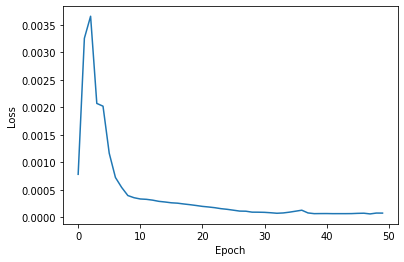

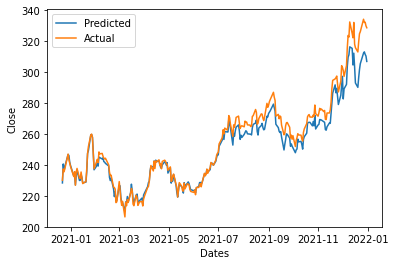

In [19]:
plt.figure(0)
plt.plot(hist.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
y_predict = lstm.predict(x_test)
l1 = data_fit.values[-260:,:]+y_predict
l2 = []
for x in y_test:
    l2.append([x])
l2 += data_fit.values[-260:,:]
l1 = scaler.inverse_transform(l1)
l2 = scaler.inverse_transform(l2)
y_predict = l1[:,-1]
y_test = l2[:,-1]
plt.figure(1)
plt.plot(d_test, y_predict, label = 'Predicted')
plt.ylabel('Close')
plt.xlabel('Dates')
plt.plot(d_test, y_test, label = 'Actual')
plt.legend()

In [20]:
rmse_test = mean_squared_error(y_test, y_predict, squared=False)
mape_test = mean_absolute_percentage_error(y_test, y_predict)
print("RMSE Test:",rmse_test)
print("MAPE Test:",mape_test)

RMSE Test: 6.7706927612995695
MAPE Test: 0.016665270787169846
